In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import argparse

plt.switch_backend('agg')
# In[3]:
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models, datasets
from torch.utils.data import Dataset, DataLoader

In [2]:

from synthetic_dataloader import *


from synthetic_utils import *


# In[5]:


from trainer_dataloader import *
from networks import *
from losses import *


# In[6]:

In [3]:

input_size = 96
batch_size = 64
num_workers = 4


cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))


# In[8]:


data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
}



Device set: cuda


In [4]:
# if independent:
# DATA_PATH = '/home/s1791387/diss/gen_shapes/'
# else:
DATA_PATH = '/home/s1791387/diss/dependent_gen/'
print(DATA_PATH)
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

/home/s1791387/diss/dependent_gen/


In [5]:
train_df = datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train'])
val_df = datasets.ImageFolder(root=VAL_PATH, transform=data_transforms['val'])
test_df = datasets.ImageFolder(root=TEST_PATH, transform=data_transforms['val'])

In [6]:
LOAD_PATH = './eo2_dep/1/weights/encoder_434_0.866.pth'

In [7]:
laftr_encoder = torch.load(LOAD_PATH)

In [8]:
gender_train = GenderDataset(train_df)
gender_valid = GenderDataset(val_df)

In [9]:
advtrain_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
advval_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

In [10]:
adversary = ClassNet()

adv_criterion = nn.BCELoss()
opt_adv = optim.Adam(adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_adv = lr_scheduler.StepLR(optimizer=opt_adv, gamma=0.99, step_size=1)

In [11]:
num_epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_adv.step()
        # train
        train_loss, train_acc = train_classifier_epoch(advtrain_loader, laftr_encoder,
                                adversary, opt_adv, adv_criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_classifier_epoch(advval_loader, laftr_encoder, adversary,
                                 adv_criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/79]	Time 2.161 (2.161)	Loss 0.8503 (0.8503)	Accuracy 0.6562 (0.6562)
Batch: [10/79]	Time 0.057 (0.455)	Loss 0.5329 (0.6113)	Accuracy 0.8281 (0.7585)
Batch: [20/79]	Time 1.385 (0.452)	Loss 0.5069 (0.5377)	Accuracy 0.7812 (0.7812)
Batch: [30/79]	Time 0.066 (0.402)	Loss 0.4255 (0.4920)	Accuracy 0.8281 (0.8070)
Batch: [40/79]	Time 1.281 (0.409)	Loss 0.3338 (0.4585)	Accuracy 0.8750 (0.8228)
Batch: [50/79]	Time 0.067 (0.391)	Loss 0.4166 (0.4389)	Accuracy 0.8438 (0.8315)
Batch: [60/79]	Time 1.295 (0.398)	Loss 0.4298 (0.4229)	Accuracy 0.8125 (0.8373)
Batch: [70/79]	Time 0.075 (0.387)	Loss 0.3542 (0.4088)	Accuracy 0.8906 (0.8413)
----------


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Avg validation loss: 0.3066298794746399 	 Accuracy: 0.898
--------------------
Epoch 0/20	Time 34.106 sec (34.106 sec)
--------------------
Epoch: 1/20


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/79]	Time 2.450 (2.450)	Loss 0.3711 (0.3711)	Accuracy 0.8594 (0.8594)
Batch: [10/79]	Time 0.055 (0.501)	Loss 0.2483 (0.2917)	Accuracy 0.9375 (0.8878)
Batch: [20/79]	Time 1.279 (0.462)	Loss 0.3241 (0.3081)	Accuracy 0.8906 (0.8772)
Batch: [30/79]	Time 0.052 (0.406)	Loss 0.3606 (0.3049)	Accuracy 0.8750 (0.8866)
Batch: [40/79]	Time 1.564 (0.418)	Loss 0.3220 (0.3023)	Accuracy 0.8906 (0.8868)
Batch: [50/79]	Time 0.061 (0.403)	Loss 0.1715 (0.3006)	Accuracy 0.9531 (0.8863)
Batch: [60/79]	Time 1.228 (0.404)	Loss 0.3290 (0.3019)	Accuracy 0.8281 (0.8824)
Batch: [70/79]	Time 0.048 (0.390)	Loss 0.2804 (0.2977)	Accuracy 0.9219 (0.8862)
----------
Avg validation loss: 0.2876768419742584 	 Accuracy: 0.872
--------------------
Epoch 1/20	Time 33.227 sec (33.667 sec)
--------------------
Epoch: 2/20
Batch: [0/79]	Time 2.152 (2.152)	Loss 0.2891 (0.2891)	Accuracy 0.8438 (0.8438)
Batch: [10/79]	Time 0.065 (0.518)	Loss 0.3683 (0.2882)	Accuracy 0.8281 (0.8750)
Batch: [20/79]	Time 1.593 (0.512)	Loss 

No handles with labels found to put in legend.


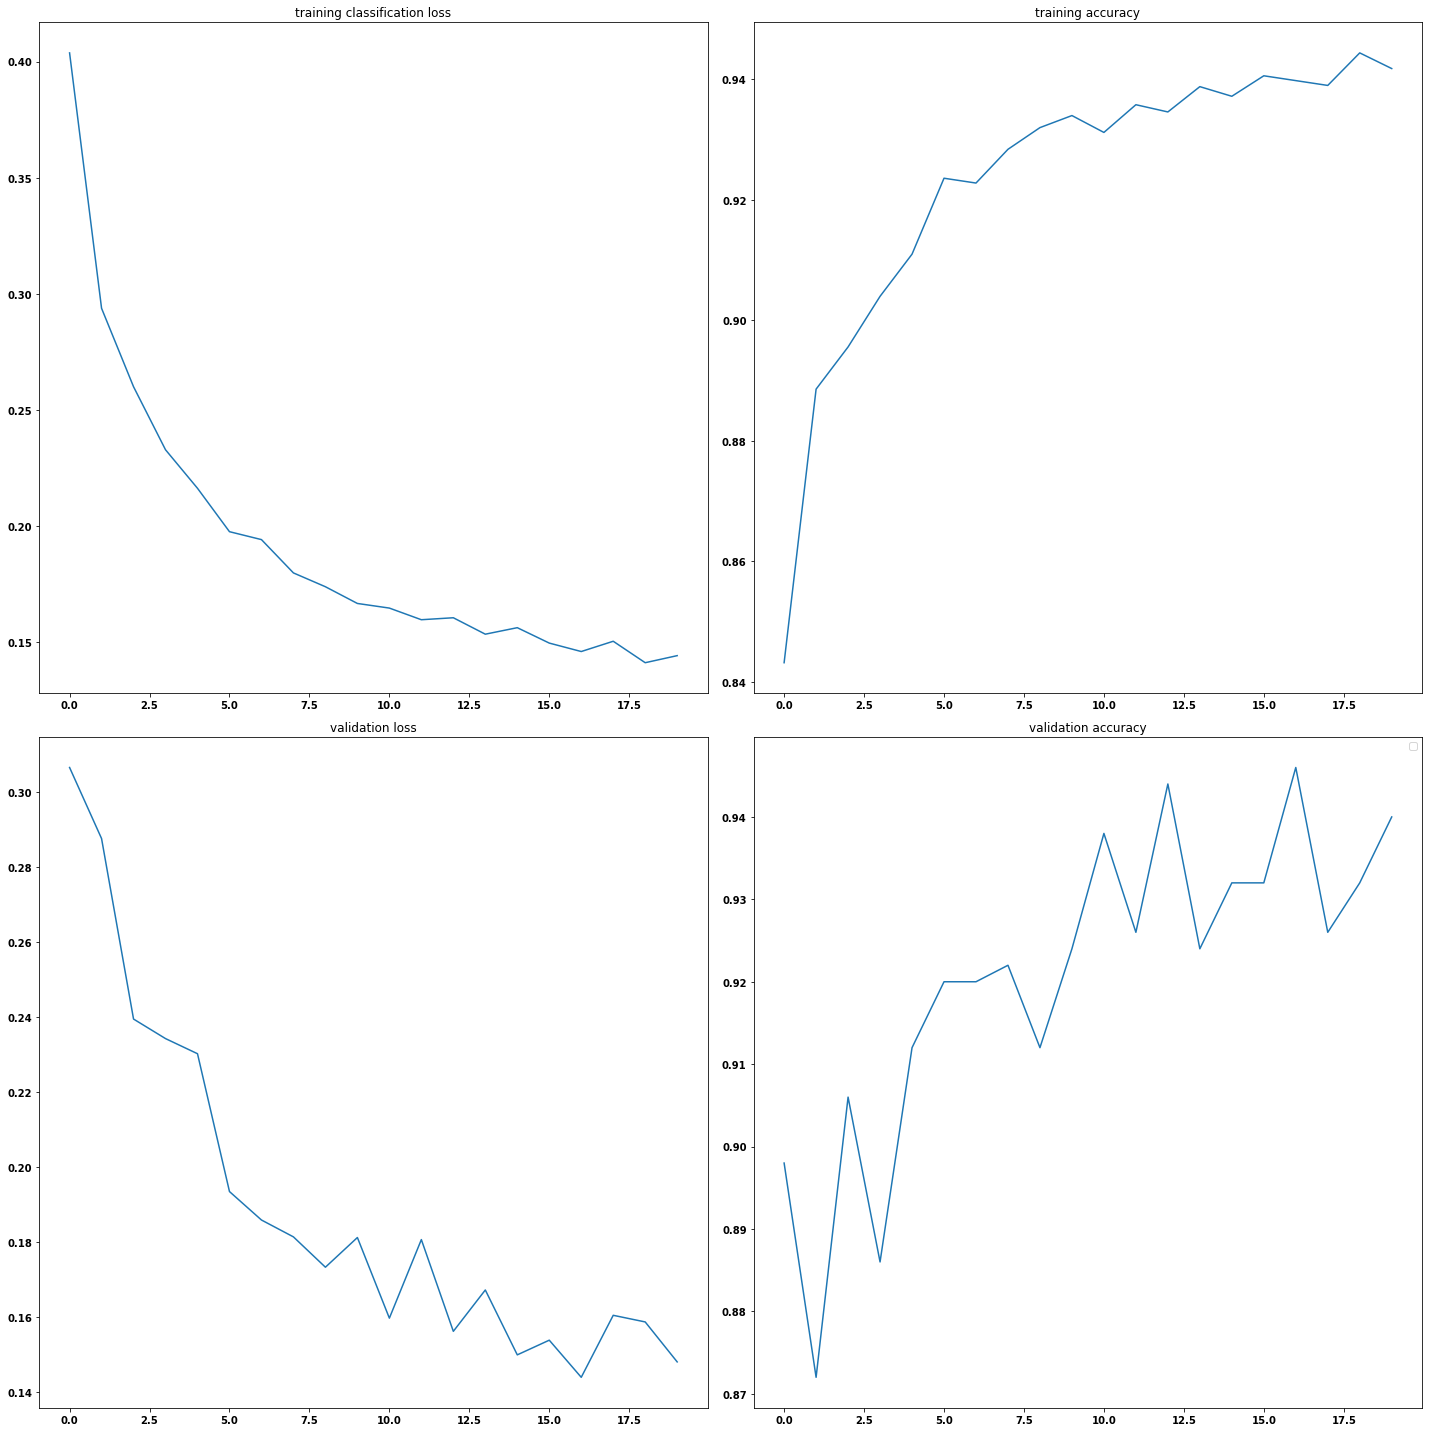

In [12]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)
plt.legend()
plt.tight_layout()